# **Data Loading & Normalization**

In [1]:
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os

BASE_PATH = "/content/drive/MyDrive/Digital Signal/UCI HAR dataset/UCI HAR Dataset/UCI HAR Dataset"

print("BASE_PATH:", os.listdir(BASE_PATH))
print("TRAIN:", os.listdir(os.path.join(BASE_PATH, "train")))
print("SIGNALS:", os.listdir(os.path.join(BASE_PATH, "train", "Inertial Signals")))


BASE_PATH: ['activity_labels.txt', 'README.txt', '.DS_Store', 'features.txt', 'features_info.txt', 'test', 'train']
TRAIN: ['X_train.txt', 'subject_train.txt', 'y_train.txt', 'Inertial Signals']
SIGNALS: ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_z_train.txt', 'body_acc_z_train.txt', 'body_gyro_x_train.txt', 'total_acc_y_train.txt', 'body_gyro_z_train.txt', 'total_acc_x_train.txt']


Loading the data

In [4]:
def load_signal_file(filepath): #loader functions
    return np.loadtxt(filepath)

def load_inertial_signals(base_path, split="train"):
    signal_path = os.path.join(base_path, split, "Inertial Signals")

    signal_files = [
        f"body_acc_x_{split}.txt",
        f"body_acc_y_{split}.txt",
        f"body_acc_z_{split}.txt",
        f"body_gyro_x_{split}.txt",
        f"body_gyro_y_{split}.txt",
        f"body_gyro_z_{split}.txt",
        f"total_acc_x_{split}.txt",
        f"total_acc_y_{split}.txt",
        f"total_acc_z_{split}.txt",
    ]

    signals = [load_signal_file(os.path.join(signal_path, f)) for f in signal_files]

    X = np.stack(signals, axis=2)  # (N, 128, 9) N being the number of windows, 128 samples per window
    # each signal is (N, 128) and there are 9 signals like that, then we stack them in the code above
    # axis = 2 is the signal channel, before that axis 0 is the window index (N), axis 1 is the time (128 samples)
    y = np.loadtxt(os.path.join(base_path, split, f"y_{split}.txt")).astype(int) - 1

    return X, y

In [5]:
X_train, y_train = load_inertial_signals(BASE_PATH, "train")
X_test, y_test   = load_inertial_signals(BASE_PATH, "test")

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (7352, 128, 9) (7352,)
Test:  (2947, 128, 9) (2947,)


We have 7352 samples (number of windows) for training and 2947 samples for test. 128 readings per window and 9 sensor channels.

**Normalization**

Each sensor signal has different units and different scales (fractions of gravity or radians/sec) so, in order to train CNN better, we need to normalize the signals so that they are all on comparable scales.

In [6]:
mean = X_train.mean(axis=(0, 1), keepdims=True)
std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-8
#we do not recalculate mean and std on test data bc that would be like a data leakage. test data should be working on unseen future data.
X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std


After normalization, each channel has mean = 0, and standard deviation = 1.

**Converting NumPy data to PyTorch tensors**

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader


In [8]:
X_train_t = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).permute(0, 2, 1)
# we reshaped the axes, now it is (samples, channels, time)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

print(X_train_t.shape)  # (7352, 9, 128)


torch.Size([7352, 9, 128])


Because pytorch expects : (batch, channels, time). Here, we convert numpy arrays to a format which pytorch can work on.

# Dataset & DataLoader

We are creating a custom dataset that inherits from torch.utils.data.Dataset so pytorch now knows that this object can be iterated over to get training samples.

In [9]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = X # X and y are stored as attributes of the dataset object
        self.y = y
        # X[i] is one 2.56s multichannel window and y[i] is the activity label for that window
    def __len__(self): #how many samples does this dataset contain
        return len(self.y)

    def __getitem__(self, idx): #function to get 1 sample
        return self.X[idx], self.y[idx]


Function train_loader below groups samples into mini-batches and shuffles sample order in every epoch. This prevents the model from memorizing order and improves generalization.

Shuffling is False for test_loader because evaluation must be deterministic. Order consistency matters for confusion matrix and reproducibility. No learning happens during testing.

In [10]:
train_loader = DataLoader(
    HARDataset(X_train_t, y_train_t),
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    HARDataset(X_test_t, y_test_t),
    batch_size=64,
    shuffle=False
)


We define a custom PyTorch Dataset where each item corresponds to one fixed-length inertial signal window and its activity label. The DataLoader handles batching and shuffling, enabling efficient and stable training of the CNN.

# **CNN-1D Architecture**

In [12]:
import torch.nn as nn

Here, we are defining a 1D CNN that takes multichannel time-series signals as input, learns temporal patterns directly from data and outputs one activity label per signal window.

In [13]:
class CNN1D(nn.Module):
  def __init__(self, num_channels=9, num_classes=6): #9 signal channels and 6 types of activities
      super().__init__() # initializes PyTorch

      self.features = nn.Sequential( #feature extraction
          # (9, 128) -> (64, 128)
          #first convolutional block
          nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.MaxPool1d(2), #(64, 64), output shape is -> (batch, classes)


          #second convolutional block, learns higher-level motion patterns
          nn.Conv1d(64, 128, kernel_size=5, padding=2),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.MaxPool1d(2),  # (128, 32)

          #(128, 32) -> (256, 32)
          nn.Conv1d(128, 256, kernel_size=3, padding=1),
          nn.BatchNorm1d(256),
          nn.ReLU(),

          #global pooling, compresses time dimension
          nn.AdaptiveAvgPool1d(1) #(256, 1)
      )

      self.classifier = nn.Linear(256, num_classes) #takes the 256 learned features and outputs 6 class scores

  def forward(self, x):
    x = self.features(x)
    x = x.squeeze(-1) #(N, 256, 1) → (N, 256)
    return self.classifier(x)



The CNN applies a hierarchy of temporal filters to raw inertial signals.
Early layers capture short-term motion patterns, while deeper layers model higher-level activity dynamics. Global average pooling aggregates information over time before classification.

# **Training Setup**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN1D().to(device)
criterion = nn.CrossEntropyLoss() #this applies softmax internally
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #Adam is used to update model weights during training


Since CNN rusn much faster on GPU, if GPU is available we use cuda, if not, we use cpu.

Adam is used as an adaptive gradient optimizer as it works good with CNNs, handles different gradient scales and is common in HAR literature.

# **Training Loop**

In [15]:
def train_epoch(model, loader): #this function trains the model for one full epoch
    model.train()
    total_loss, correct = 0, 0

    for X, y in loader: #loader is a DataLoader object
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad() #resetting the gradients as pytorch accumulates gradients by default
        out = model(X)
        loss = criterion(out, y)
        loss.backward() #backpropagation
        optimizer.step()

        total_loss += loss.item() * X.size(0) #total loss for the batch
        correct += (out.argmax(1) == y).sum().item() #count correct predictions

    return total_loss / len(loader.dataset), correct / len(loader.dataset) #return average loss and accuracy over all samples


During each epoch, the CNN processes batches of multichannel time-series windows. For each batch, we compute the classification error, backpropagate gradients through the temporal filters, and update them using the Adam optimizer.

In [16]:
def eval_epoch(model, loader): #evaluates the model on validation/test data
    model.eval() #switch model to evaluation mode
    total_loss, correct = 0, 0

    with torch.no_grad(): #disable gradient computation
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)

            total_loss += loss.item() * X.size(0)
            correct += (out.argmax(1) == y).sum().item() #argmax being the predicted class, compare it with true label and count correct predictions

    return total_loss / len(loader.dataset), correct / len(loader.dataset) #returns average loss and accuracy over entire dataset


In [17]:
for epoch in range(15): #train the model for 15 epochs
    train_loss, train_acc = train_epoch(model, train_loader)
    test_loss, test_acc   = eval_epoch(model, test_loader)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train acc: {train_acc:.3f} | "
        f"Test acc: {test_acc:.3f}"
    )


Epoch 01 | Train acc: 0.919 | Test acc: 0.908
Epoch 02 | Train acc: 0.948 | Test acc: 0.908
Epoch 03 | Train acc: 0.948 | Test acc: 0.925
Epoch 04 | Train acc: 0.947 | Test acc: 0.929
Epoch 05 | Train acc: 0.955 | Test acc: 0.927
Epoch 06 | Train acc: 0.954 | Test acc: 0.932
Epoch 07 | Train acc: 0.953 | Test acc: 0.932
Epoch 08 | Train acc: 0.954 | Test acc: 0.928
Epoch 09 | Train acc: 0.954 | Test acc: 0.939
Epoch 10 | Train acc: 0.956 | Test acc: 0.935
Epoch 11 | Train acc: 0.954 | Test acc: 0.921
Epoch 12 | Train acc: 0.956 | Test acc: 0.934
Epoch 13 | Train acc: 0.956 | Test acc: 0.938
Epoch 14 | Train acc: 0.958 | Test acc: 0.926
Epoch 15 | Train acc: 0.957 | Test acc: 0.924


From the accuracies throughout the epochs, we can say that the model learns quickly. The highest test accuracy is ≈ 93.9%. Towards the end, slight overfitting starts as the test accuracy starts decreasing a bit. There is a small gap, which indicates good generalization.

Early stopping may be applied as best epoch is around 9 or 13.

# **DEMO**

Activity Labels:

In [18]:
activity_names = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]


# **Single Sample Prediction Function**

In [19]:
import torch

def predict_single(model, X, y, idx):
    model.eval()
    with torch.no_grad():
        x = X[idx].unsqueeze(0).to(device)  # (1, 9, 128)
        pred = model(x).argmax(dim=1).item()

    true_label = activity_names[y[idx]]
    pred_label = activity_names[pred]
    return true_label, pred_label


# **Visualization Function**

In [20]:
import matplotlib.pyplot as plt


In [23]:
def demo_sample(idx):
    print(idx)
    true_label, pred_label = predict_single(model, X_test_t, y_test, idx)

    fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

    # Body Acceleration
    axes[0].plot(X_test_t[idx, 0].cpu(), label="Acc X")
    axes[0].plot(X_test_t[idx, 1].cpu(), label="Acc Y")
    axes[0].plot(X_test_t[idx, 2].cpu(), label="Acc Z")
    axes[0].set_title("Body Acceleration")
    axes[0].legend()

    # Gyroscope
    axes[1].plot(X_test_t[idx, 3].cpu(), label="Gyro X")
    axes[1].plot(X_test_t[idx, 4].cpu(), label="Gyro Y")
    axes[1].plot(X_test_t[idx, 5].cpu(), label="Gyro Z")
    axes[1].set_title("Body Gyroscope")
    axes[1].legend()

    # Total Acceleration
    axes[2].plot(X_test_t[idx, 6].cpu(), label="Total Acc X")
    axes[2].plot(X_test_t[idx, 7].cpu(), label="Total Acc Y")
    axes[2].plot(X_test_t[idx, 8].cpu(), label="Total Acc Z")
    axes[2].set_title("Total Acceleration")
    axes[2].legend()

    plt.suptitle(f"True: {true_label}   |   Predicted: {pred_label}", fontsize=14)
    plt.xlabel("Time (samples)")
    plt.tight_layout()
    plt.show()


# **Random Sample for Demo**

273


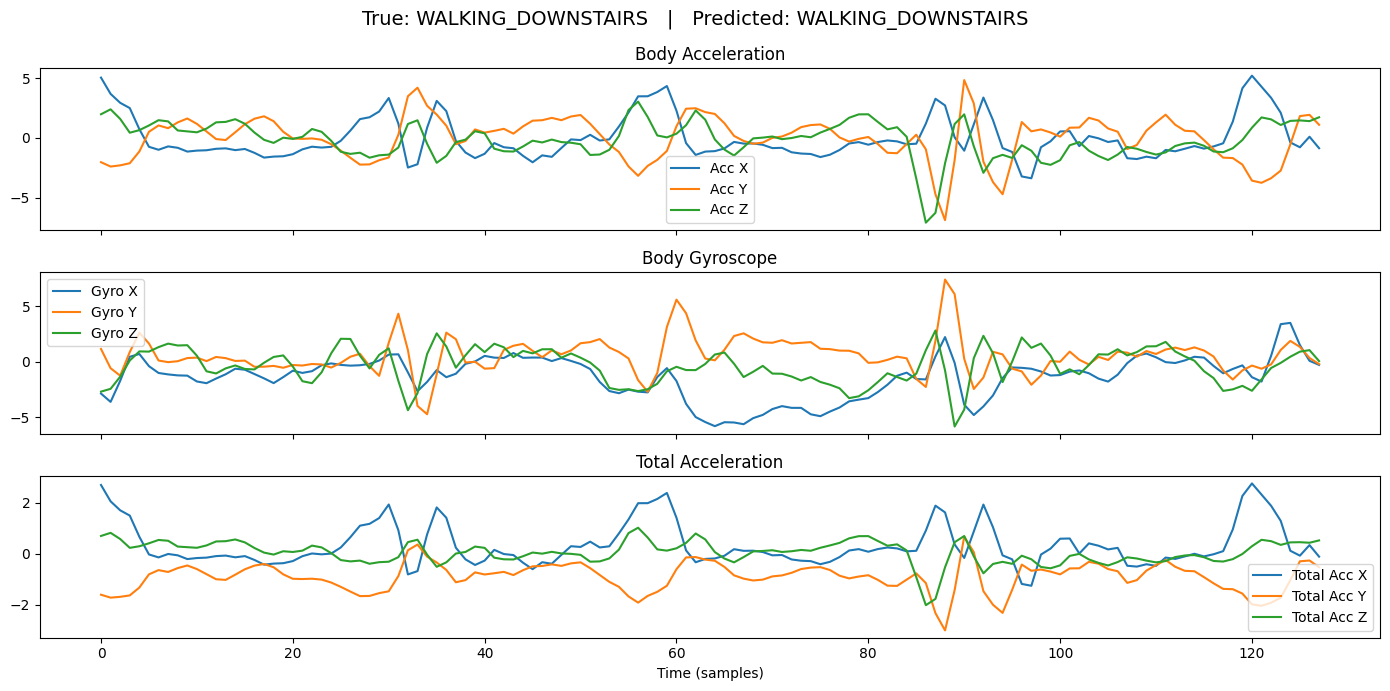

In [25]:
import random
demo_sample(random.randint(0, len(X_test_t)-1))